In [1]:
# This is a third attempt to find a better solution.
# This attempt will keep the cardholder_id and age.
# The previous attempts predicted fraud with a static 70% confidence level.
# We will use precision recall to adjust the threshold and also calibrate the model's probabilities.

###################################
# Step 1: Import and Load the Data
###################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV

q1_fraud_df = pd.read_csv('datasets/2023_fraud_claims.csv')
claims_2023_df = pd.read_csv('datasets/2023_claims.csv')

claims_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653697 entries, 0 to 1653696
Data columns (total 32 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   masked_claim_reference_number  1653697 non-null  object 
 1   date_filled                    1653697 non-null  int64  
 2   claim_type                     1653697 non-null  object 
 3   customer_id                    1653697 non-null  int64  
 4   patient_paid_amount            0 non-null        float64
 5   copay_amount                   1653697 non-null  float64
 6   basis_of_reimbursement         1653697 non-null  object 
 7   refund                         1607527 non-null  object 
 8   transaction_status             1653697 non-null  object 
 9   masked_cardholder_id           1653697 non-null  object 
 10  age                            1653696 non-null  float64
 11  prescriber_id                  1653697 non-null  int64  
 12  prescriber_nam

In [2]:
##########################################
# Step 2: Merge and Create is_fraud Column
##########################################
merged_df = claims_2023_df.merge(
    q1_fraud_df[['masked_claim_reference_number']],
    on='masked_claim_reference_number',
    how='left',
    indicator=True
)

merged_df['is_fraud'] = np.where(merged_df['_merge'] == 'both', 1, 0)
merged_df.drop(columns=['_merge'], inplace=True)

In [3]:
#################################
# Step 3: Filter Q1 and Q2-Q4 Data
#################################
q1_data = merged_df[(merged_df['date_filled'] >= 20230101) & (merged_df['date_filled'] <= 20230331)]
q2_q4_data = merged_df[(merged_df['date_filled'] >= 20230401) & (merged_df['date_filled'] <= 20231231)]

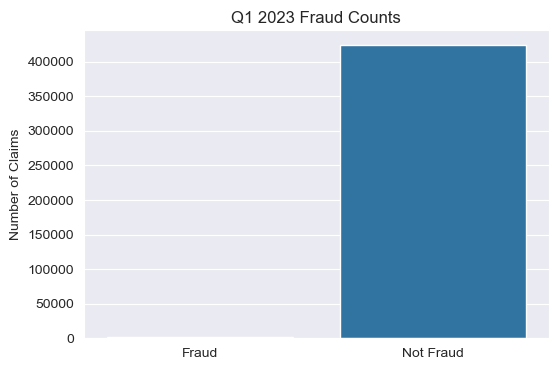

Q1 2023 Fraud Rate: 0.38%


In [4]:
##############################
# Step 4: Visualize Q1 Fraud Rate
##############################
q1_fraud_rate = q1_data['is_fraud'].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=['Fraud', 'Not Fraud'],
            y=[q1_data['is_fraud'].sum(), (len(q1_data) - q1_data['is_fraud'].sum())])
plt.title('Q1 2023 Fraud Counts')
plt.ylabel('Number of Claims')
plt.show()
print("Q1 2023 Fraud Rate: {:.2f}%".format(q1_fraud_rate * 100))

In [5]:
#######################################
# Step 5: Prepare Data for Model Training
#######################################
X_train = q1_data.drop(['is_fraud', 'masked_claim_reference_number'], axis=1)
y_train = q1_data['is_fraud']
X_test = q2_q4_data.drop(['is_fraud', 'masked_claim_reference_number'], axis=1)
y_test = q2_q4_data['is_fraud']


In [6]:
#######################################
# Step 6: Clean and Encode the Data
#######################################
cols_to_drop = []
if 'patient_paid_amount' in X_train.columns and X_train['patient_paid_amount'].isnull().all():
    cols_to_drop.append('patient_paid_amount')
if 'pharmacy_type' in X_train.columns and X_train['pharmacy_type'].isnull().all():
    cols_to_drop.append('pharmacy_type')

X_train = X_train.drop(cols_to_drop, axis=1, errors='ignore')
X_test = X_test.drop(cols_to_drop, axis=1, errors='ignore')

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('Unknown')
    X_test[col] = X_test[col].fillna('Unknown')

le = LabelEncoder()
for col in categorical_cols:
    combined_categories = pd.concat([X_train[col], X_test[col]]).astype(str).unique().tolist()
    le.fit(combined_categories)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

numeric_cols = X_train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [7]:
###############################
# Step 7: Train the Model
###############################
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [8]:
###########################################
# Step 8: Probability Calibration
###########################################
# Calibrate the model's probabilities using isotonic regression.
calibrated_model = CalibratedClassifierCV(base_estimator=best_model, method='isotonic', cv='prefit')
calibrated_model.fit(X_train, y_train)

# Now use calibrated_model for predictions
y_train_proba = calibrated_model.predict_proba(X_train)[:,1]
y_train_pred = (y_train_proba >= 0.5).astype(int)  # initial threshold = 0.5

print("Training Set Metrics with Calibration (threshold=0.5):")
print(classification_report(y_train, y_train_pred))
print("AUC Score (Train):", roc_auc_score(y_train, y_train_proba))

Training Set Metrics with Calibration (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424152
           1       1.00      1.00      1.00      1599

    accuracy                           1.00    425751
   macro avg       1.00      1.00      1.00    425751
weighted avg       1.00      1.00      1.00    425751

AUC Score (Train): 0.9999999904160757


In [9]:
##############################################################
# Step 9: Select Threshold Using Precision-Recall Curve
##############################################################
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)

desired_rate = 0.38
best_threshold = 0.5  # default
best_diff = 1.0
for t in thresholds:
    pred_labels = (y_train_proba >= t).astype(int)
    rate = pred_labels.mean()
    diff = abs(rate - desired_rate)
    if diff < best_diff:
        best_diff = diff
        best_threshold = t

print(f"Selected threshold to match fraud rate ~{desired_rate}: {best_threshold:.4f}")

Selected threshold to match fraud rate ~0.38: 0.0714


In [10]:
#######################################################
# Step 10: Evaluate Model with New Threshold on Q1 Data
#######################################################
y_train_pred = (y_train_proba >= best_threshold).astype(int)
print("Training Set Metrics with Adjusted Threshold:")
print(classification_report(y_train, y_train_pred))
print("AUC Score (Train):", roc_auc_score(y_train, y_train_proba))
print("Predicted Fraud Rate (Q1) with threshold {:.4f}: {:.2f}%".format(best_threshold, y_train_pred.mean()*100))

Training Set Metrics with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424152
           1       0.99      1.00      1.00      1599

    accuracy                           1.00    425751
   macro avg       1.00      1.00      1.00    425751
weighted avg       1.00      1.00      1.00    425751

AUC Score (Train): 0.9999999904160757
Predicted Fraud Rate (Q1) with threshold 0.0714: 0.38%


In [11]:
###############################################
# Step 11: Predict on Q2-Q4 with the New Threshold
###############################################
y_test_proba = calibrated_model.predict_proba(X_test)[:,1]
predicted_fraud = (y_test_proba >= best_threshold).astype(int)

if y_test.nunique() > 1:
    print("Q2-Q4 Test Set Metrics with Adjusted Threshold:")
    print(classification_report(y_test, predicted_fraud))
    print("AUC Score (Test):", roc_auc_score(y_test, y_test_proba))

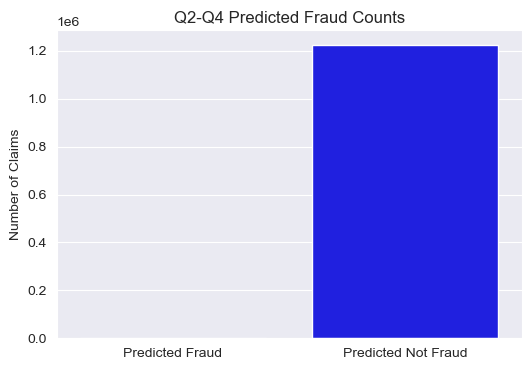

Q2-Q4 Predicted Fraud Rate: 0.26%


In [12]:
###############################
# Step 12: Visualize Q2-Q4 Results
###############################
predicted_fraud_rate = predicted_fraud.mean()

plt.figure(figsize=(6,4))
sns.barplot(x=['Predicted Fraud', 'Predicted Not Fraud'],
            y=[predicted_fraud.sum(), len(predicted_fraud)-predicted_fraud.sum()],
            color='blue')
plt.title('Q2-Q4 Predicted Fraud Counts')
plt.ylabel('Number of Claims')
plt.show()

print("Q2-Q4 Predicted Fraud Rate: {:.2f}%".format(predicted_fraud_rate * 100))

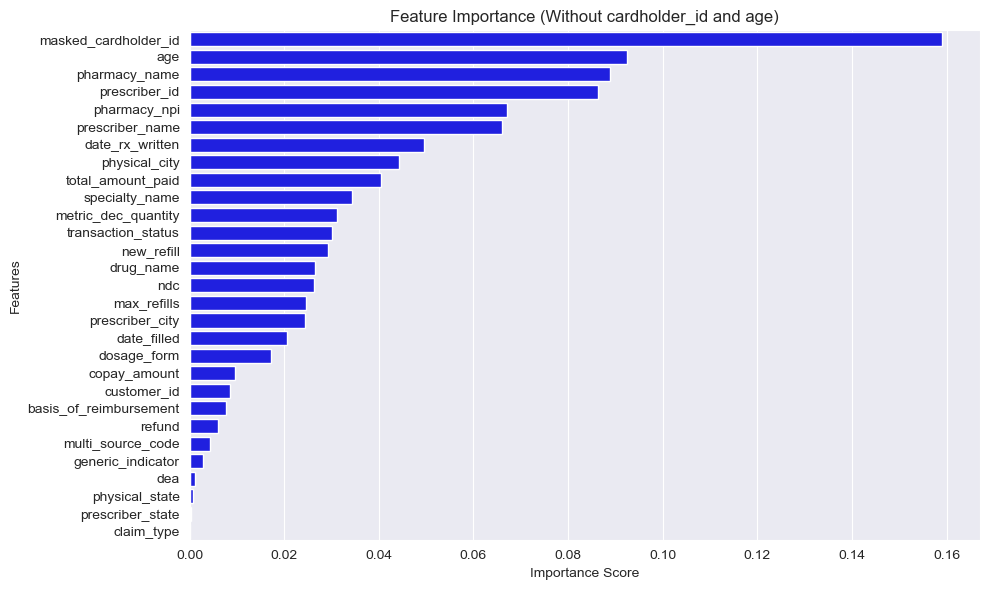

In [13]:
#####################################
# Step 13: Feature Importance Plot
#####################################
importances = best_model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, color='blue')
plt.title('Feature Importance (Without cardholder_id and age)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

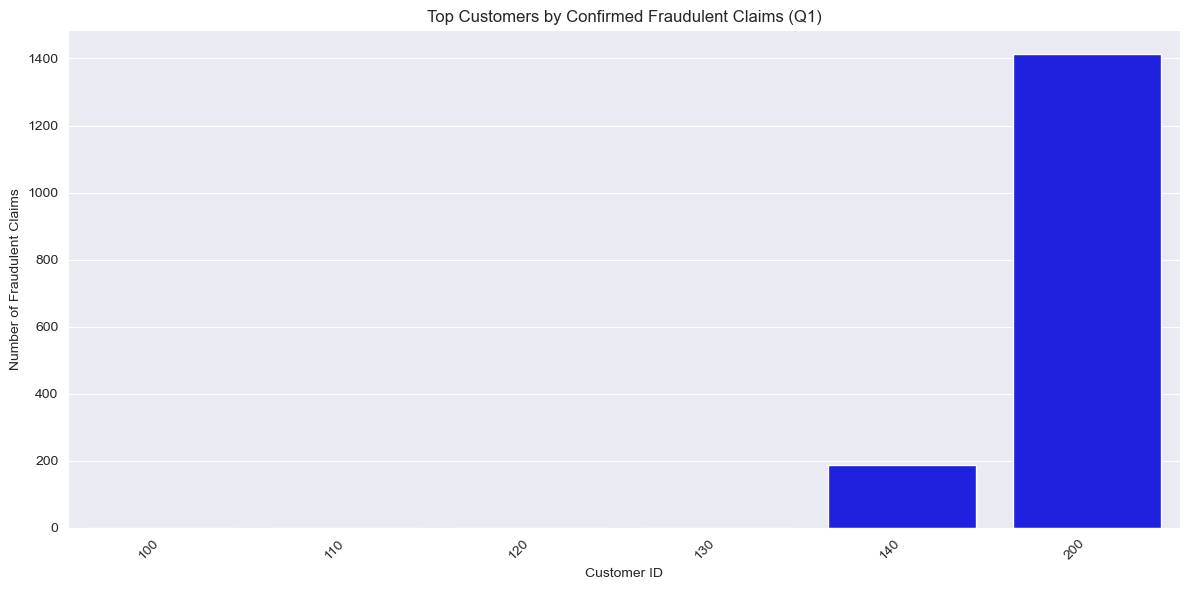

In [16]:
#####################################
# Step 13: Summarize the actual fraud by client_id
#####################################
# Group Q1 data by customer_id and sum the fraud flags
fraud_counts_q1 = q1_data.groupby('customer_id')['is_fraud'].sum().reset_index()

# Sort by number of fraudulent claims (descending)
fraud_counts_q1 = fraud_counts_q1.sort_values('is_fraud', ascending=False)

# Select top customers for visualization (e.g., top 20)
top_q1_customers = fraud_counts_q1.head(20)

# Plot a vertical bar chart with customer_id on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_id', y='is_fraud', data=top_q1_customers, color='blue')

plt.title('Top Customers by Confirmed Fraudulent Claims (Q1)')
plt.xlabel('Customer ID')
plt.ylabel('Number of Fraudulent Claims')

# Rotate x-axis labels if needed for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

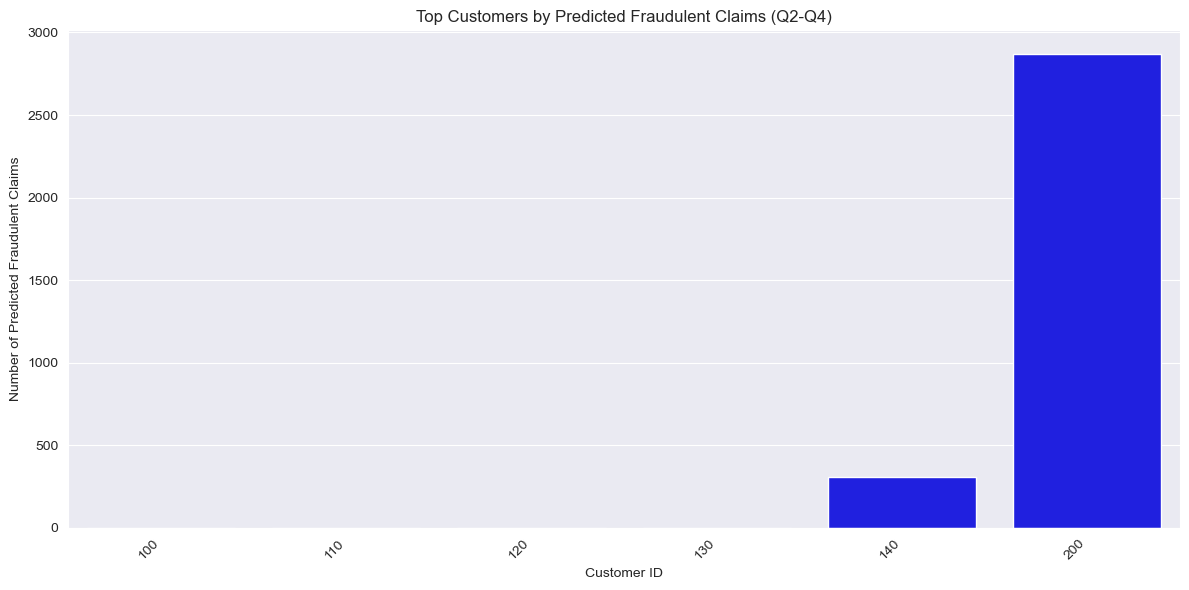

In [15]:
#####################################
# Step 14: Summarize the predicted fraud by client_id
#####################################
# Make a copy of X_test and add predictions
X_test_with_preds = X_test.copy()
X_test_with_preds['predicted_fraud'] = predicted_fraud

# Ensure 'customer_id' is in X_test. If it's only in q2_q4_data, bring it over:
X_test_with_preds['customer_id'] = q2_q4_data['customer_id'].values

# Group by customer_id and sum predicted fraudulent claims
fraud_counts_by_customer = X_test_with_preds.groupby('customer_id')['predicted_fraud'].sum().reset_index()

# Sort by number of predicted fraudulent claims (descending)
fraud_counts_by_customer = fraud_counts_by_customer.sort_values('predicted_fraud', ascending=False)

# Select top customers for visualization (e.g., top 20)
top_customers = fraud_counts_by_customer.head(20)

# Plot a vertical bar chart with customer_id on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_id', y='predicted_fraud', data=top_customers, color='blue')

plt.title('Top Customers by Predicted Fraudulent Claims (Q2-Q4)')
plt.xlabel('Customer ID')
plt.ylabel('Number of Predicted Fraudulent Claims')

# Rotate x-axis labels if needed for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [18]:
#####################################
# Step 15: Class Rebalancing and Retraining
#####################################
from imblearn.over_sampling import SMOTE

# Apply SMOTE to rebalance the training data
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

# Retrain the model on the balanced dataset
model_balanced = RandomForestClassifier(random_state=42)

# We can reuse the same param_grid or create a new one
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Hyperparameter tuning on the balanced data
grid_search_balanced = GridSearchCV(model_balanced, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_balanced.fit(X_train_balanced, y_train_balanced)

best_model_balanced = grid_search_balanced.best_estimator_
print("Best parameters after rebalancing:", grid_search_balanced.best_params_)

Best parameters after rebalancing: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [19]:
#################################################
# Step 16: Calibrate Model's Probabilities Again
#################################################

from sklearn.calibration import CalibratedClassifierCV

# Calibrate the model trained on balanced data
calibrated_model_balanced = CalibratedClassifierCV(base_estimator=best_model_balanced, method='isotonic', cv='prefit')
calibrated_model_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluate on the training set
y_train_bal_proba = calibrated_model_balanced.predict_proba(X_train_balanced)[:,1]
y_train_bal_pred = (y_train_bal_proba >= 0.5).astype(int)

print("Training Set Metrics on Balanced Data (threshold=0.5):")
print(classification_report(y_train_balanced, y_train_bal_pred))
print("AUC Score (Train, Balanced):", roc_auc_score(y_train_balanced, y_train_bal_proba))

Training Set Metrics on Balanced Data (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424152
           1       1.00      1.00      1.00    424152

    accuracy                           1.00    848304
   macro avg       1.00      1.00      1.00    848304
weighted avg       1.00      1.00      1.00    848304

AUC Score (Train, Balanced): 1.0


In [20]:
#################################################
# Step 17: Adjust Threshold Using Precision-Recall on Balanced Data
#################################################
# We still want to choose a threshold that matches the known Q1 fraud rate.
desired_rate = 0.38
precision, recall, thresholds = precision_recall_curve(y_train_balanced, y_train_bal_proba)

best_threshold = 0.5
best_diff = 1.0
for t in thresholds:
    pred_labels = (y_train_bal_proba >= t).astype(int)
    rate = pred_labels.mean()
    diff = abs(rate - desired_rate)
    if diff < best_diff:
        best_diff = diff
        best_threshold = t

print(f"Selected threshold after balancing to match fraud rate ~{desired_rate}: {best_threshold:.4f}")

# Evaluate again with the new threshold on training set
y_train_bal_pred = (y_train_bal_proba >= best_threshold).astype(int)
print("Training Set Metrics with Adjusted Threshold (Balanced):")
print(classification_report(y_train_balanced, y_train_bal_pred))
print("AUC Score (Train, Balanced):", roc_auc_score(y_train_balanced, y_train_bal_proba))
print("Predicted Fraud Rate (Q1, Balanced) with threshold {:.4f}: {:.2f}%".format(best_threshold, y_train_bal_pred.mean()*100))

Selected threshold after balancing to match fraud rate ~0.38: 1.0000
Training Set Metrics with Adjusted Threshold (Balanced):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424152
           1       1.00      1.00      1.00    424152

    accuracy                           1.00    848304
   macro avg       1.00      1.00      1.00    848304
weighted avg       1.00      1.00      1.00    848304

AUC Score (Train, Balanced): 1.0
Predicted Fraud Rate (Q1, Balanced) with threshold 1.0000: 50.00%


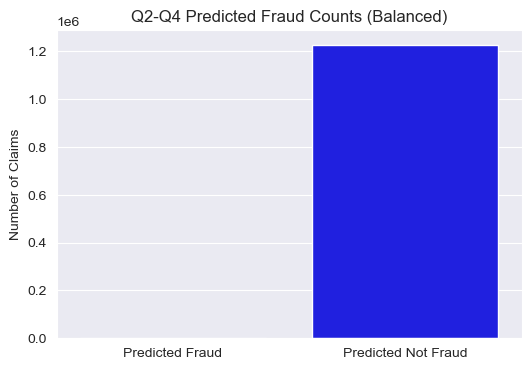

Q2-Q4 Predicted Fraud Rate (Balanced): 0.07%


In [21]:
#################################################
# Step 18: Predict on Q2-Q4 with New Balanced Model and Threshold
#################################################
y_test_bal_proba = calibrated_model_balanced.predict_proba(X_test)[:,1]
predicted_fraud_bal = (y_test_bal_proba >= best_threshold).astype(int)

if y_test.nunique() > 1:
    print("Q2-Q4 Test Set Metrics (Balanced):")
    print(classification_report(y_test, predicted_fraud_bal))
    print("AUC Score (Test, Balanced):", roc_auc_score(y_test, y_test_bal_proba))

predicted_fraud_rate_bal = predicted_fraud_bal.mean()
plt.figure(figsize=(6,4))
sns.barplot(x=['Predicted Fraud', 'Predicted Not Fraud'],
            y=[predicted_fraud_bal.sum(), len(predicted_fraud_bal)-predicted_fraud_bal.sum()],
            color='blue')
plt.title('Q2-Q4 Predicted Fraud Counts (Balanced)')
plt.ylabel('Number of Claims')
plt.show()

print("Q2-Q4 Predicted Fraud Rate (Balanced): {:.2f}%".format(predicted_fraud_rate_bal * 100))

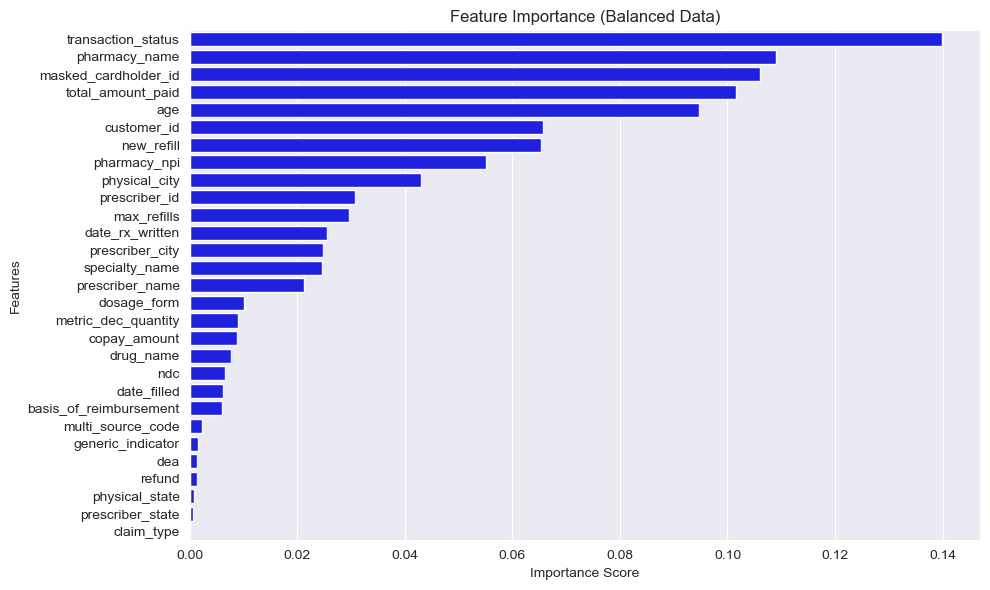

In [24]:
#################################################
# Step 19: Feature Importance on Balanced Model
#################################################
importances_bal = best_model_balanced.feature_importances_
feature_names = X_train.columns
feat_imp_bal_df = pd.DataFrame({'feature': feature_names, 'importance': importances_bal})
feat_imp_bal_df = feat_imp_bal_df.sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_bal_df, color='blue')
plt.title('Feature Importance (Balanced Data)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

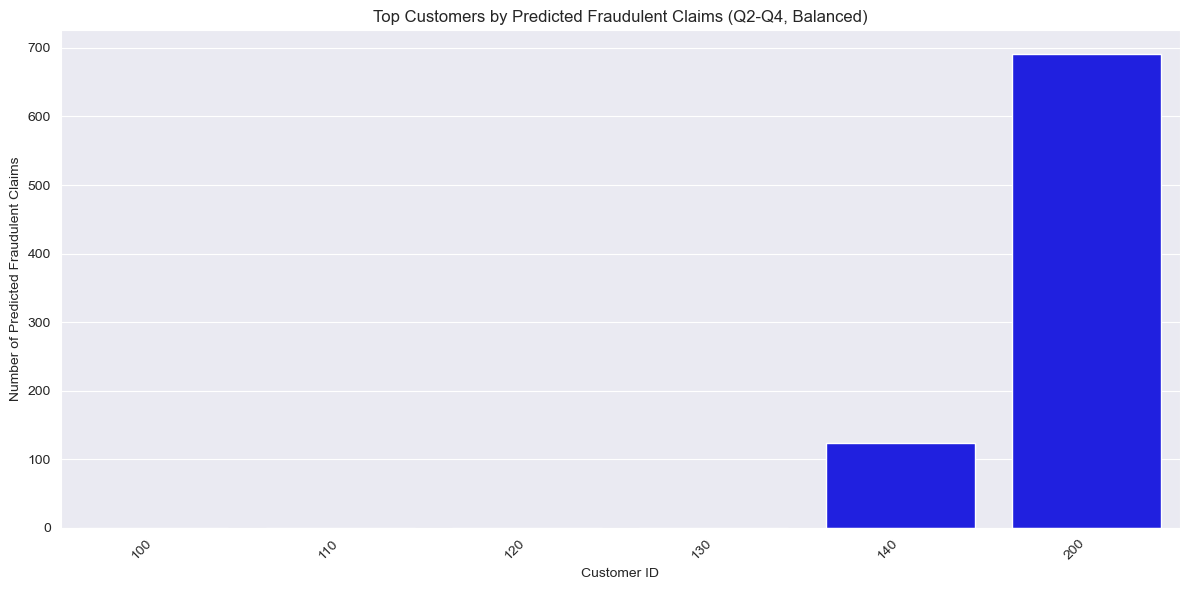

In [23]:
# Make a copy of X_test and add the balanced predictions
X_test_with_bal_preds = X_test.copy()
X_test_with_bal_preds['predicted_fraud_bal'] = predicted_fraud_bal

# Ensure that 'customer_id' is aligned. We assume q2_q4_data has same ordering as X_test
X_test_with_bal_preds['customer_id'] = q2_q4_data['customer_id'].values

# Group by customer_id and sum the predicted fraudulent claims
fraud_counts_by_customer_bal = X_test_with_bal_preds.groupby('customer_id')['predicted_fraud_bal'].sum().reset_index()

# Sort by number of predicted fraudulent claims in descending order
fraud_counts_by_customer_bal = fraud_counts_by_customer_bal.sort_values('predicted_fraud_bal', ascending=False)

# Select top customers for visualization (for example, top 20)
top_customers_bal = fraud_counts_by_customer_bal.head(20)

# Plot a vertical bar chart with customer_id on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_id', y='predicted_fraud_bal', data=top_customers_bal, color='blue')

plt.title('Top Customers by Predicted Fraudulent Claims (Q2-Q4, Balanced)')
plt.xlabel('Customer ID')
plt.ylabel('Number of Predicted Fraudulent Claims')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()